In [4]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from general_utils.plots import plot_detections
from deep_learning.models.class_based_detector import ClassificationBasedDetector
from deep_learning.models.base_classifier import CNNClasssifier
from database.dataset import INBreast_Dataset

import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import models

In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [1]:
# model definition
model_path = '/home/jseia/Desktop/ml-dl/data/dl_runs/resnet50_02/resnet50_02.pt'
model_ckpt = torch.load(model_path)
cfg = model_ckpt['configuration']
model = CNNClasssifier(
    activation=getattr(nn, cfg['model']['activation'])(),
    dropout=cfg['model']['dropout'],
    fc_dims=cfg['model']['fc_dims'],
    freeze_weights=cfg['model']['freeze_weights'],
    backbone=cfg['model']['backbone'],
    pretrained=cfg['model']['pretrained'],
)
model = model.model
model.load_state_dict(model_ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False

NameError: name 'torch' is not defined

In [ ]:
# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    patch_size=224,
    stride=25,
    min_breast_fraction_patch=0.5,
    batch_size=24,
    device=device,
    nms=True,
    iou_threshold=0.2)

In [ ]:
sample = db[3]
img = sample['img']
detections = detector.detect(img)

100%|██████████| 276/276 [01:55<00:00,  2.38it/s]


In [27]:
detections.shape

(23, 5)

: 

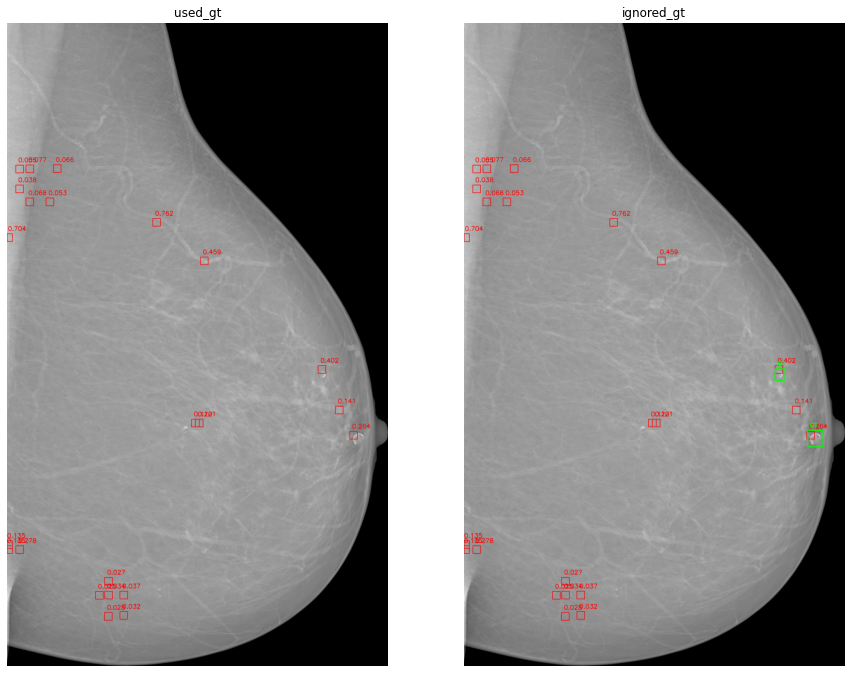

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
plot_detections(detections, img, k=12, gt_bboxes=sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections, img, k=12, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()

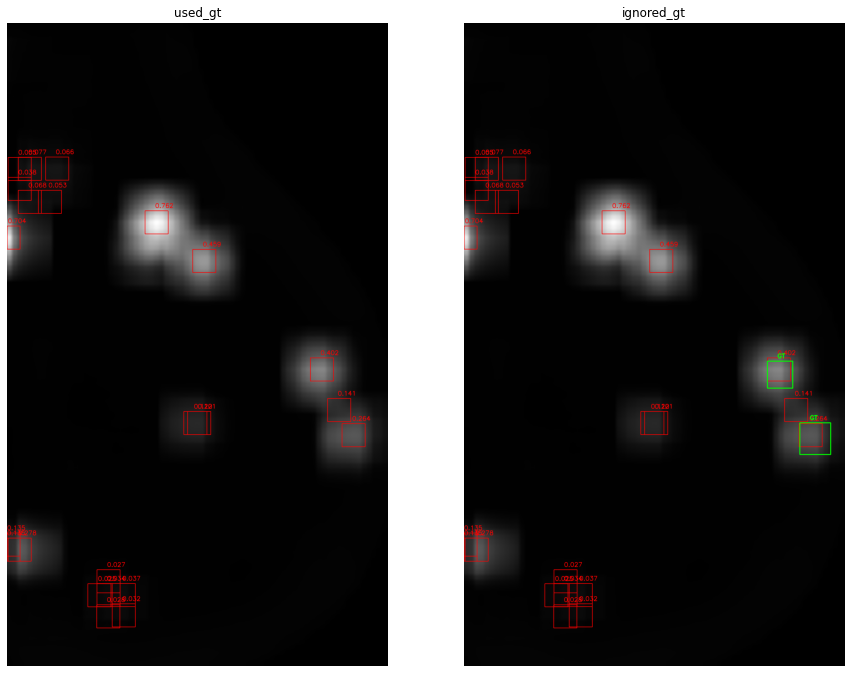

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
plot_detections(detections, detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections, detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()

#### Effect of stride

100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


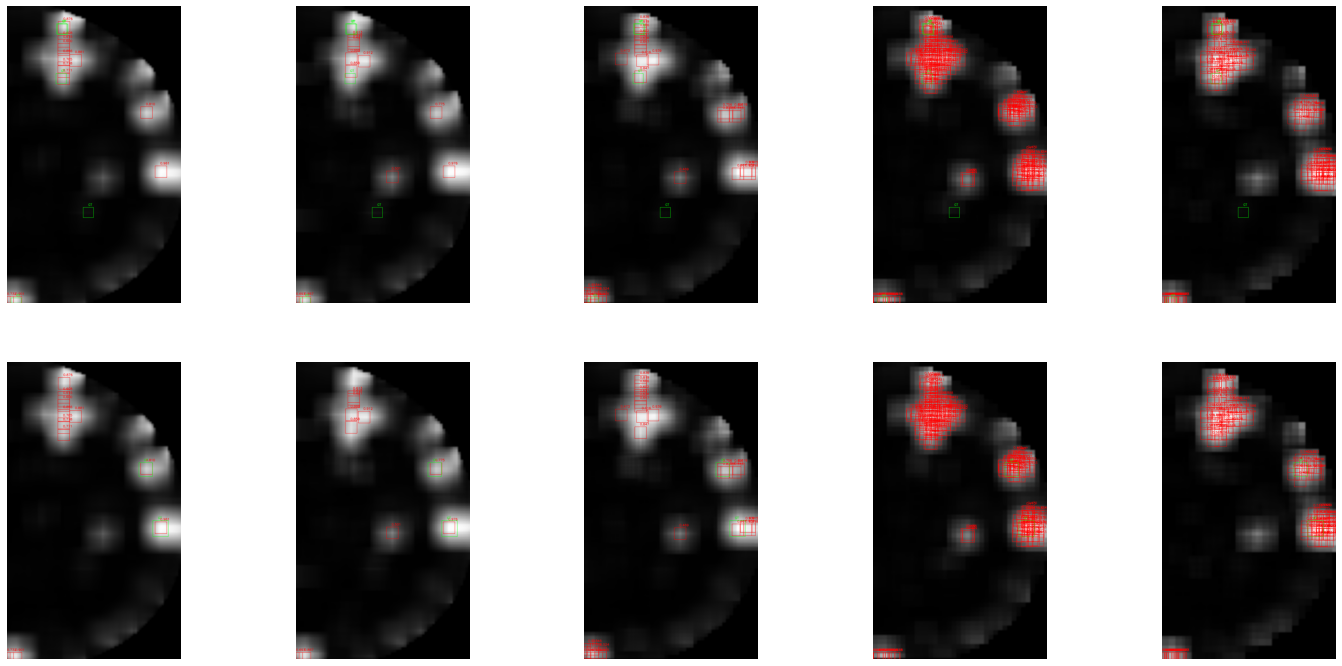

In [26]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='avg',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.2)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(25, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

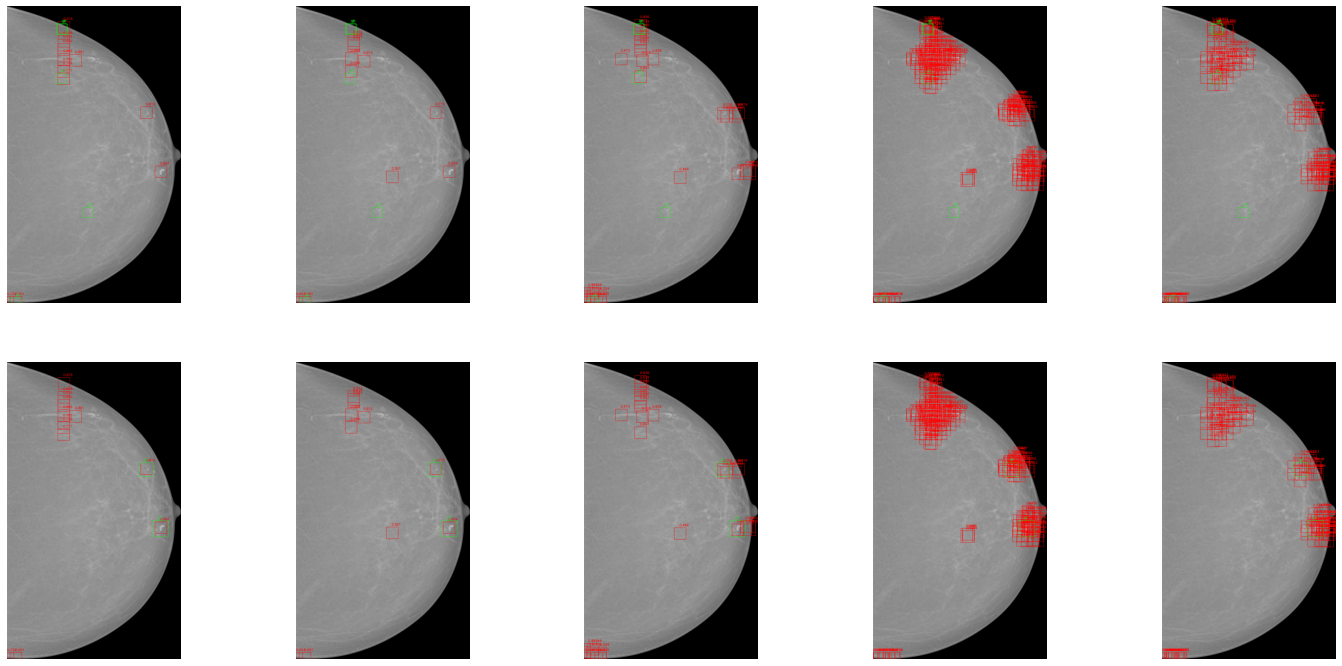

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(25, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of smoothing

100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


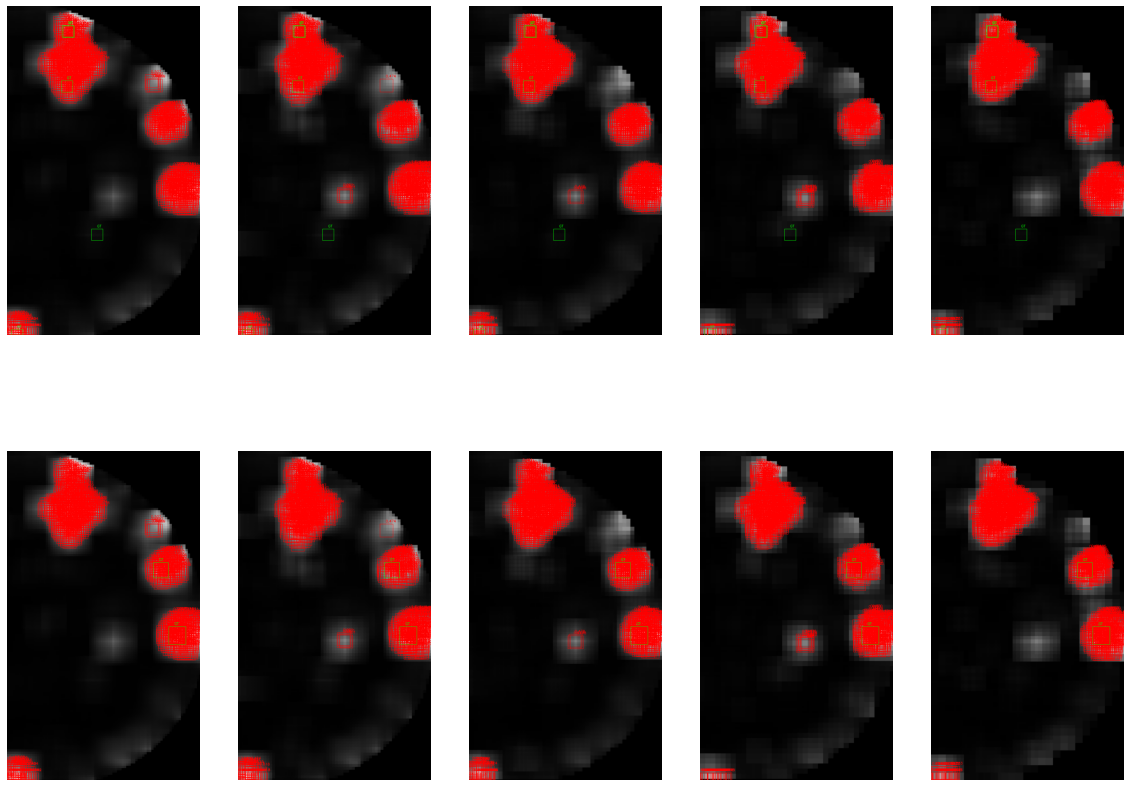

In [12]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='avg',
    post_proc=False, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

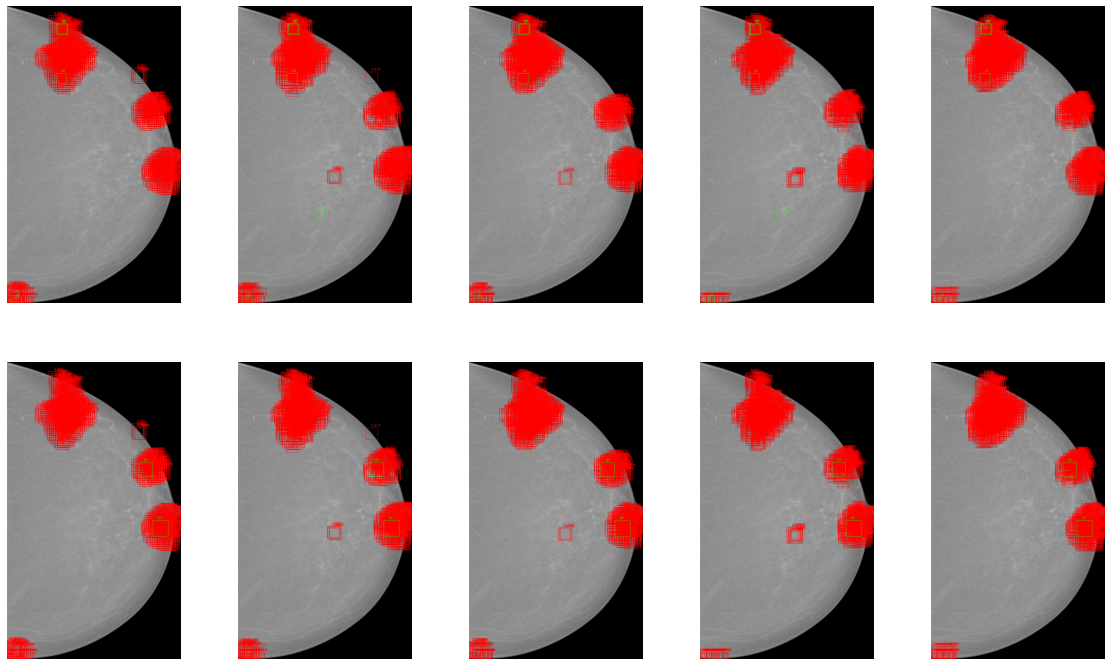

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of normalization

100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


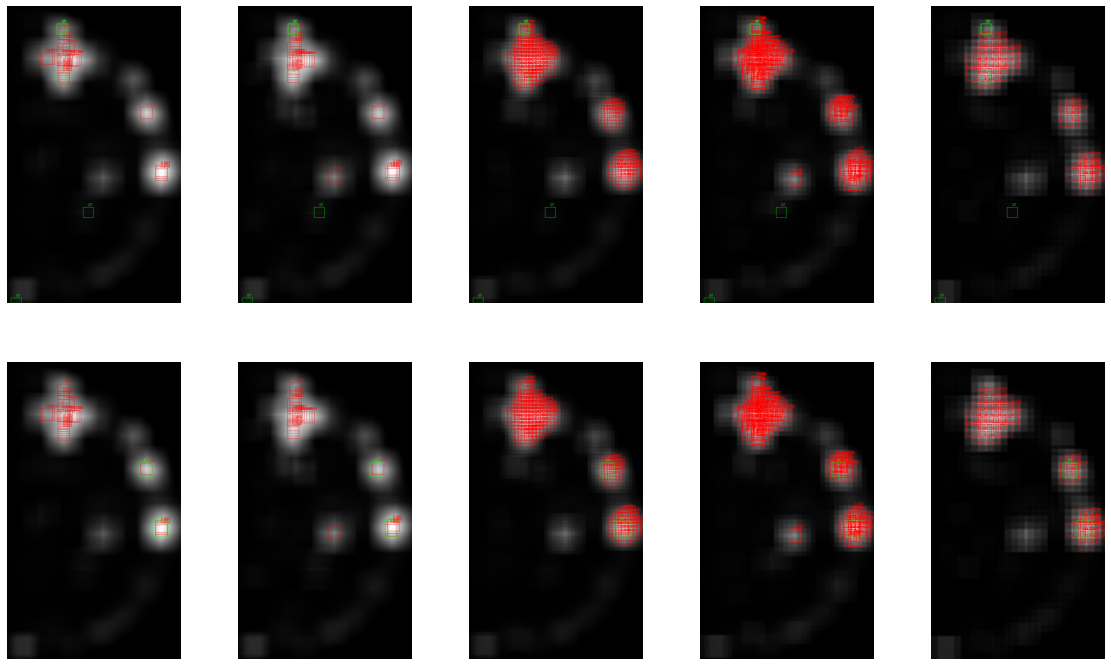

In [6]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='score', norm_kind='min_max',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.2)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

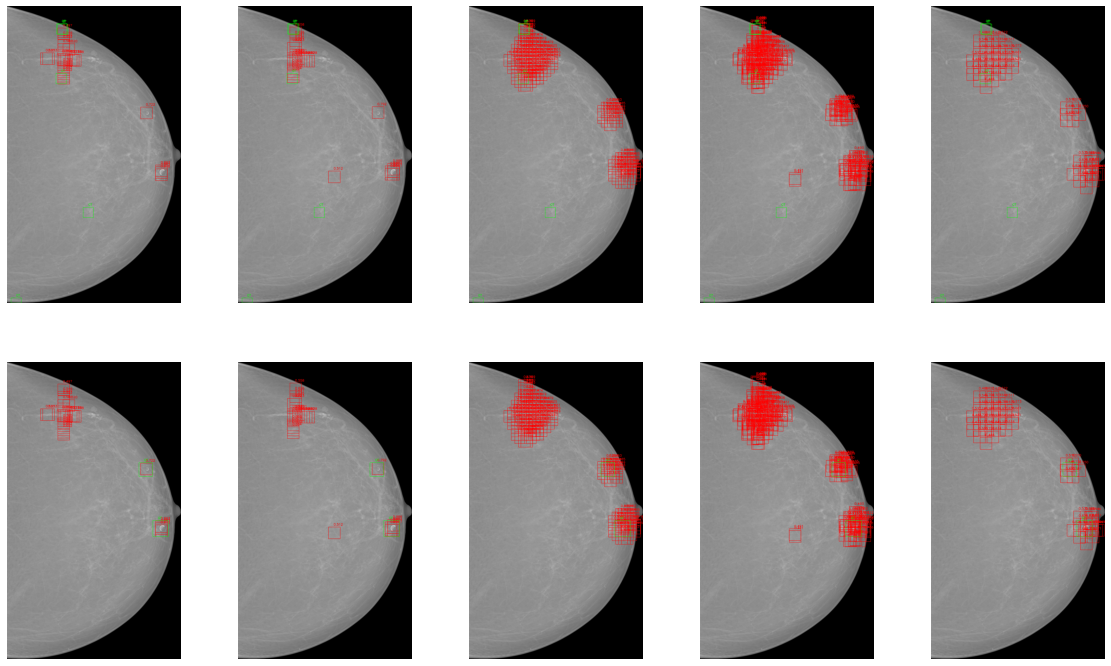

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of prediction kind

100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


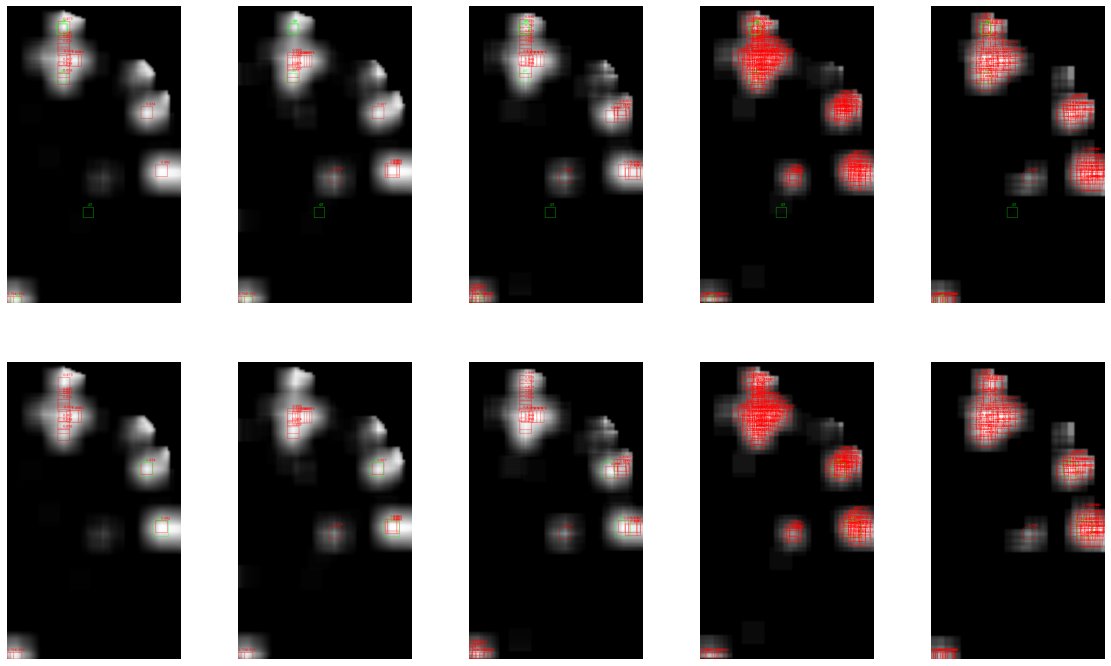

In [8]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='avg',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

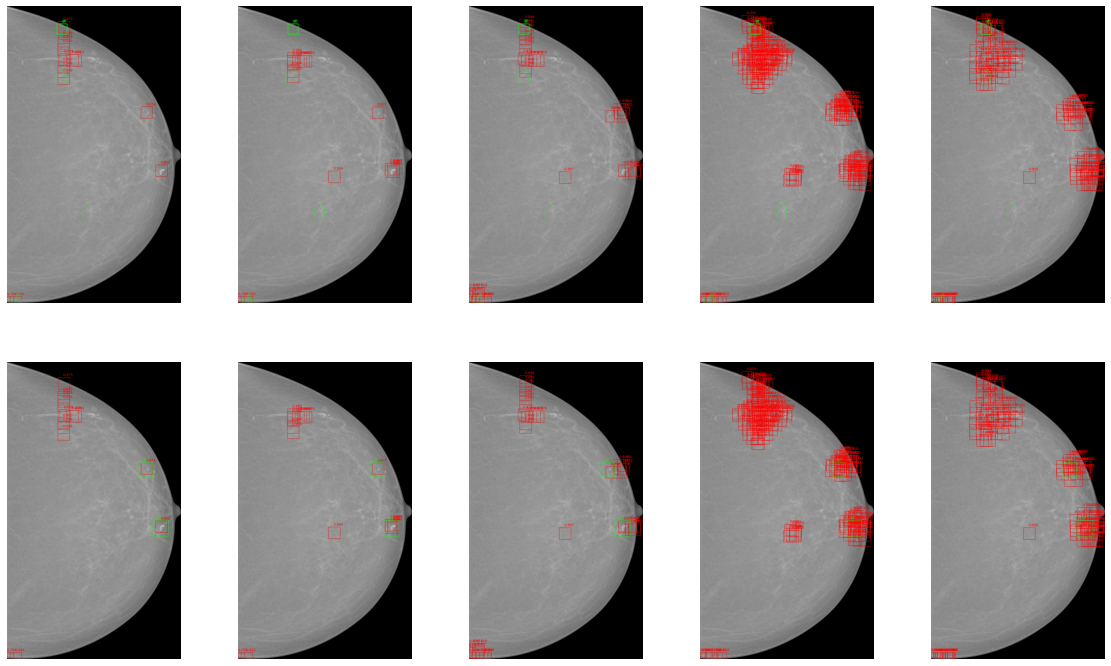

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


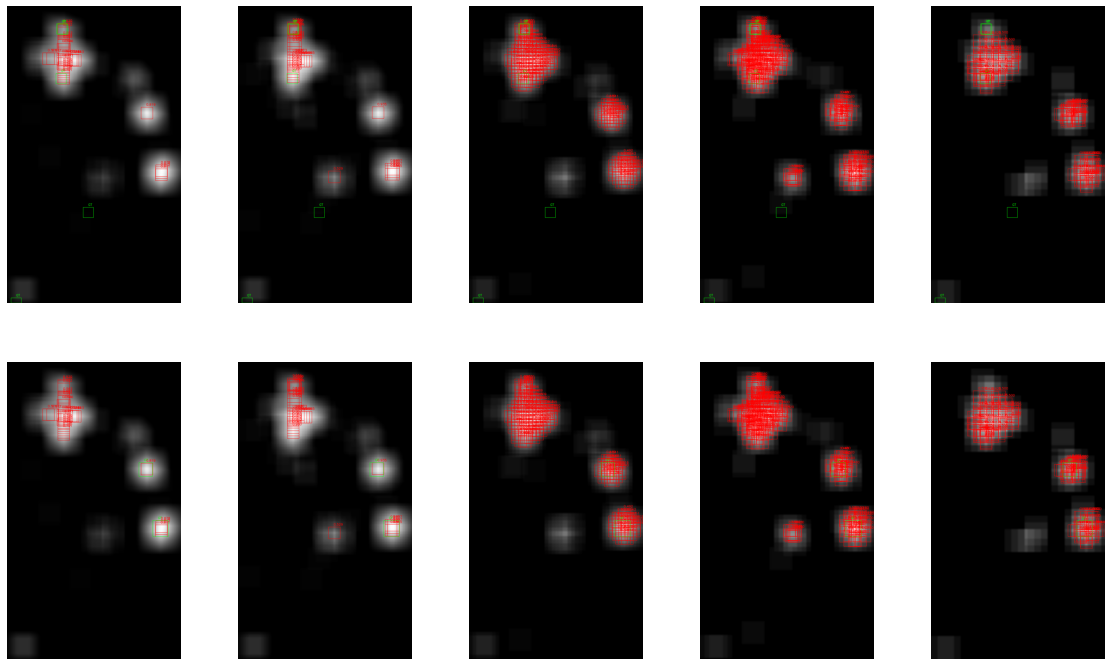

In [10]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='min_max',
    post_proc=True, patch_size=224, stride=25, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, stride in enumerate([20, 25, 35, 45, 65], 0):
    detector.stride = stride
    detections[stride] = detector.detect(img)
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[stride], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

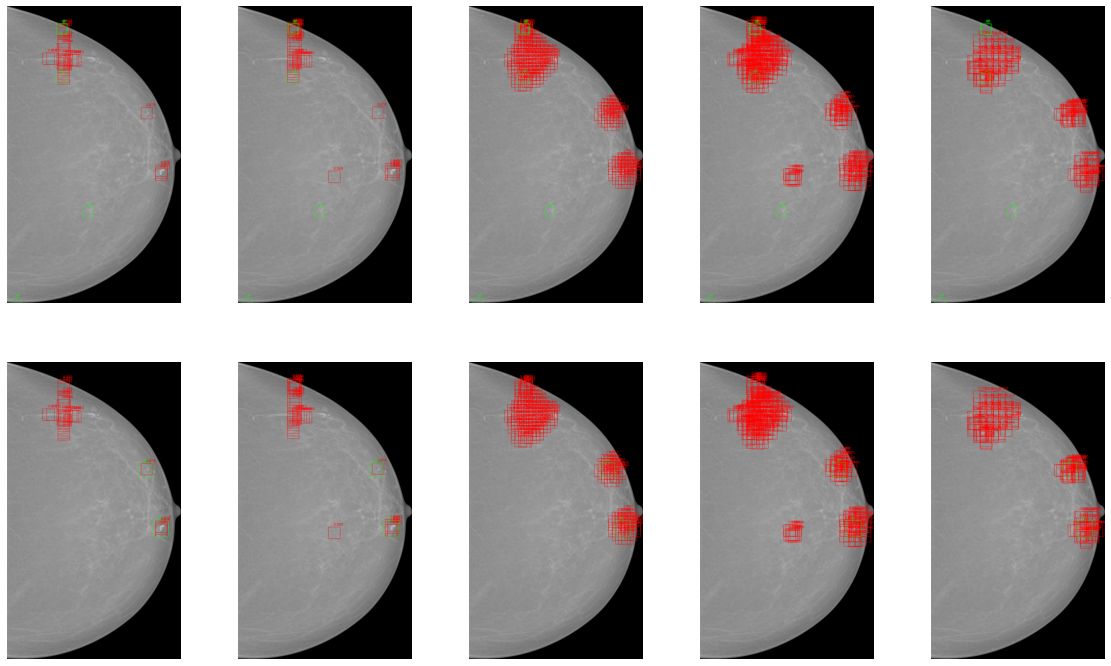

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

#### Effect of threshold

100%|██████████| 343/343 [00:47<00:00,  7.30it/s]


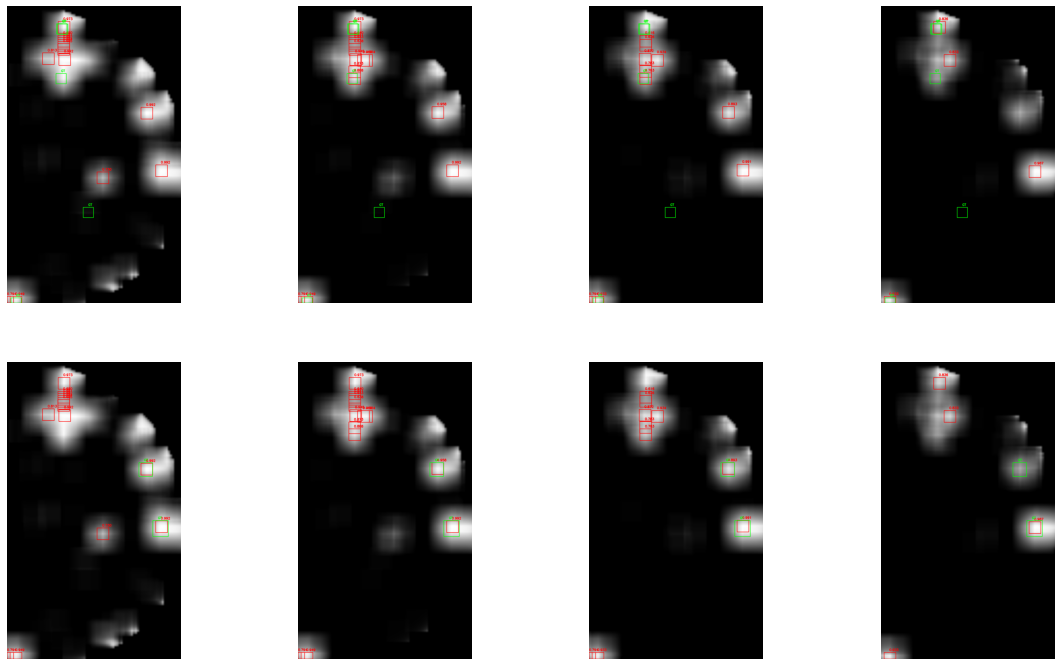

In [6]:
detector = ClassificationBasedDetector(
    model, threshold=0.4660137891769409, pred_kind='binary', norm_kind='avg',
    post_proc=True, patch_size=224, stride=20, min_breast_fraction_patch=0.5,
    batch_size=24, device=device, nms=True, iou_threshold=0.)

detections = {}
fig, ax = plt.subplots(2, 4, figsize=(20, 12))
for k, threshold in enumerate([0.2, 0.4, 0.6, 0.8], 0):
    detector.threshold = threshold
    detections[threshold] = detector.detect(img)
    plot_detections(detections[threshold], detector.saliency_map, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(detections[threshold], detector.saliency_map, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()

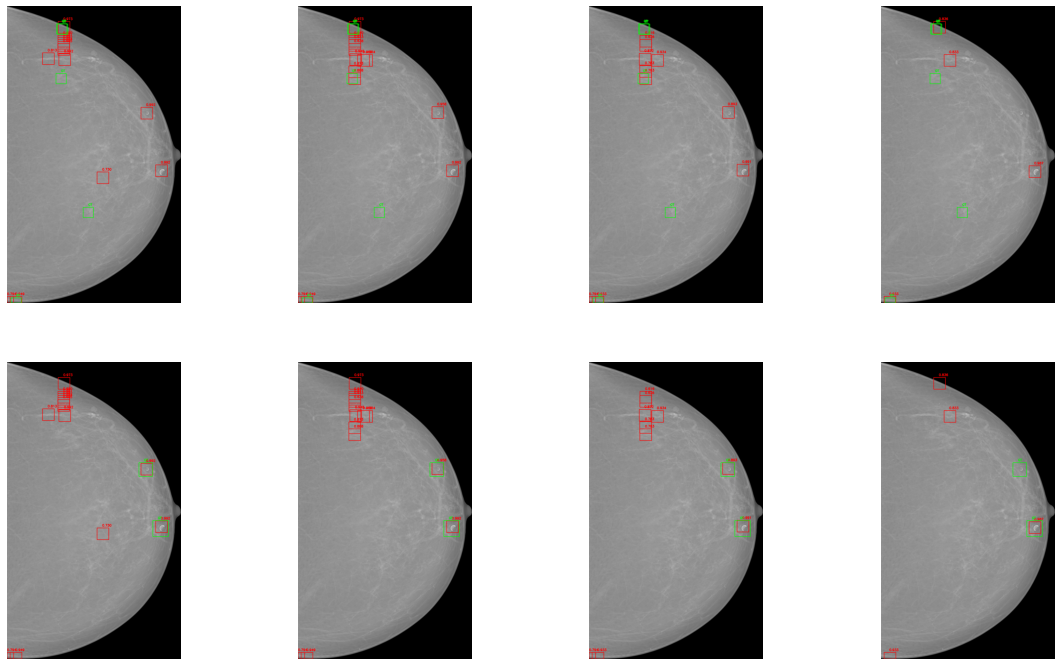

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12))
for k, (stride, dets) in enumerate(detections.items(), 0):
    plot_detections(dets, img, k=50, gt_bboxes=sample['lesion_bboxes'], ax=ax[0, k])
    plot_detections(dets, img, k=50, gt_bboxes=sample['ignored_lesion_bboxes'], ax=ax[1, k])
plt.show()